# Debug MNIST

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from tensorflow.examples.tutorials.mnist import input_data
import pdb

np.random.seed(0)

# Load Data

In [ ]:
mnist = input_data.read_data_sets('MNIST-Dataset', one_hot=True)

In [ ]:
train_x_raw = mnist.train.images
train_y_raw = mnist.train.labels
valid_x_raw = mnist.validation.images
valid_y_raw = mnist.validation.labels
test_x_raw = mnist.test.images
test_y_raw = mnist.test.labels

## Explore Data

In [ ]:
def plot_mnist(data_x, data_y, n):
    fig = plt.figure(figsize=[16,9])
    for i in range(n):
        ax = fig.add_subplot(n//8, 8, i+1)
        ax.imshow(data_x[i].reshape([28,28]))
        ax.axis('off')
        idx = int(np.nonzero(data_y[i])[0])
        ax.set_title(idx)
    plt.show()

In [ ]:
plot_mnist(train_x_raw, train_y_raw, 32)

In [ ]:
plot_mnist(valid_x_raw, valid_y_raw, 8)

In [ ]:
plot_mnist(test_x_raw, test_y_raw, 8)

In [ ]:
plt.hist(train_x_raw[0:100].flatten(), bins=100);

In [ ]:
print('train mean:', train_x_raw.mean(), 'std', train_x_raw.std())
print('valid mean:', valid_x_raw.mean(), 'std', valid_x_raw.std())
print('test mean:', test_x_raw.mean(), 'std', test_x_raw.std())

## Preprocess Data

In [ ]:
tx_mean = train_x_raw.mean()
tx_std = train_x_raw.std()
train_x = (train_x_raw - tx_mean)/tx_std
valid_x = (valid_x_raw - tx_mean)/tx_std
test_x = (test_x_raw - tx_mean)/tx_std
train_y = train_y_raw
valid_y = valid_y_raw
test_y = test_y_raw
print('train mean:', train_x.mean(), 'std', train_x.std())
print('valid mean:', valid_x.mean(), 'std', valid_x.std())
print('test mean:', test_x.mean(), 'std', test_x.std())
print(train_x.shape, train_y.shape)
print(valid_x.shape, valid_y.shape)
print(test_x.shape, test_y.shape)

In [ ]:
plot_mnist(train_x, train_y, 8)

# Fast import/restart

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from tensorflow.examples.tutorials.mnist import input_data
import pdb

np.random.seed(0)

mnist = input_data.read_data_sets('MNIST-Dataset', one_hot=True)

train_x_raw = mnist.train.images
train_y_raw = mnist.train.labels
valid_x_raw = mnist.validation.images
valid_y_raw = mnist.validation.labels
test_x_raw = mnist.test.images
test_y_raw = mnist.test.labels

# Preprocess
tx_mean = train_x_raw.mean()
tx_std = train_x_raw.std()
train_x = (train_x_raw - tx_mean)/tx_std
valid_x = (valid_x_raw - tx_mean)/tx_std
test_x = (test_x_raw - tx_mean)/tx_std
train_y = train_y_raw
valid_y = valid_y_raw
test_y = test_y_raw

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST-Dataset/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST-Dataset/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST-Dataset/t10k-images-idx3-ubyte.gz
Extracting MNIST-Dataset/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [2]:
def subsample_to_14_14(data):
    assert data.ndim == 2
    assert data.shape[1] == 784
    data_28x28 = data.reshape([len(data), 28, 28])  # reshape to match image resolution, new shape (nb_samples, 28, 28)
    print('28', data_28x28.shape)
    data_14x14 = data_28x28[:,::2,::2] # subsample, new shape (nb_samples, 14, 14)
    print('14', data_14x14.shape)
    data_196 = data_14x14.reshape([len(data),14*14])
    print('data_196', data_196.shape)
    assert data_196.ndim == 2
    assert data_196.shape[1] == 196
    return data_196

In [3]:
train_x = subsample_to_14_14(train_x)
valid_x = subsample_to_14_14(valid_x)
test_x = subsample_to_14_14(test_x)

28 (55000, 28, 28)
14 (55000, 14, 14)
data_196 (55000, 196)
28 (5000, 28, 28)
14 (5000, 14, 14)
data_196 (5000, 196)
28 (10000, 28, 28)
14 (10000, 14, 14)
data_196 (10000, 196)


## Build Model

In [4]:
def sigmoid(x, deriv=False):
    if deriv:
        return sigmoid(x)*(1-sigmoid(x))
    return 1 / (1 + np.exp(-x))

def tanh(x, deriv=False):
    if deriv:
        return 1. - np.tanh(x)**2
    return np.tanh(x)

def softssign(x, deriv=False):
    if deriv:
        dd = 1 + np.abs(x)
        return (dd - x*np.sign(x)) / dd**2
    return x / (1+np.abs(x))

def relu(x, deriv=False):
    if deriv:
        return 1. * (x>0)
    return np.maximum(0, x)

def lrelu(x, deriv=False):
    if deriv:
        dx = np.ones_like(x)
        dx[x < 0] = 0.01
        return dx
    return np.where(x > 0, x, x * 0.01)

In [5]:


def MSE(y, y_hat):
    assert y.ndim == 2
    assert y_hat.ndim == 2
    
    # avg over batch, sum over outputs (inner)
    return .5 * np.mean(np.sum((y-y_hat)**2, axis=-1))
    
    # no innner sum, becouse only one output
    return np.mean((y-y_hat)**2)

def acc(y, y_hat):
    return np.mean(np.argmax(y_hat, axis=-1)==np.argmax(y, axis=-1))

def fwd(x, W_hid, W_out, act_fun, ret=False):
    assert x.ndim == 2
    z_hid = x @ W_hid
    h_hid = act_fun(z_hid)  # hidden output

    z_out = h_hid @ W_out
    y_hat = sigmoid(z_out)  # SIGMOID!

    if ret:
        return y_hat, z_hid, h_hid, z_out
    return y_hat

def backprop(x, y, W_hid, W_out, act_fun):
    assert x.ndim == 2
    assert y.ndim == 2
    
    y_hat, z_hid, h_hid, z_out = fwd(x, W_hid, W_out, act_fun, ret=True)
    
    ro_out = (y-y_hat) * -1 * sigmoid(z_out, deriv=True)  # SIGMOID
    dW_out = h_hid.T @ ro_out / len(x)
    
    ro_hid = (ro_out @ W_out.T) * act_fun(z_hid, deriv=True)
    dW_hid = x.T @ ro_hid / len(x)
    
    return dW_hid, dW_out


    

## Numerical gradient check (optional)

In [ ]:
def ngrad(x, y, W_hid, W_out, act_fun):
    
    eps = 1e-6
    
    gW_hid = np.zeros_like(W_hid)
    for r in range(W_hid.shape[0]):
        for c in range(W_hid.shape[1]):
            W_hid_plus = W_hid.copy()
            W_hid_minus = W_hid.copy()
            W_hid_plus[r,c] += eps
            W_hid_minus[r,c] -= eps
            loss_plus = MSE(y, fwd(x, W_hid_plus, W_out, act_fun))
            loss_minus = MSE(y, fwd(x, W_hid_minus, W_out, act_fun))
            gW_hid[r,c] = (loss_plus-loss_minus) / (2*eps)

    gW_out = np.zeros_like(W_out)
    for r in range(W_out.shape[0]):
        for c in range(W_out.shape[1]):
            W_out_plus = W_out.copy()
            W_out_minus = W_out.copy()
            W_out_plus[r,c] += eps
            W_out_minus[r,c] -= eps
            loss_plus = MSE(y, fwd(x, W_hid, W_out_plus, act_fun))
            loss_minus = MSE(y, fwd(x, W_hid, W_out_minus, act_fun))
            gW_out[r,c] = (loss_plus-loss_minus) / (2*eps)
    return gW_hid, gW_out

In [ ]:
dW_hid, dW_out = backprop(train_x[0:3], train_y[0:3], W_hid, W_out, act_fun)
ngW_hid, ngW_out = ngrad(train_x[0:3], train_y[0:3], W_hid, W_out, act_fun)

In [ ]:
assert np.allclose(dW_hid, ngW_hid)
assert np.allclose(dW_out, ngW_out)

## Train Loop - with traces

In [15]:
n_in = 196   # 784
n_hid = 128  # 128             # try 8, 128(def.), 
n_out = 10
lr = .03     # 0.03                # try 10, 1(best), 0.03, 0.0003

n_batch = 100
act_fun = sigmoid
completed_epochs = 0

np.random.seed(0)

# Initialize weights
var_hid = np.sqrt(1/n_in)             # try:  0.001,  sqrt(1/n_in),  1
var_out = np.sqrt(1/n_hid)
W_hid = np.random.normal(0.0, var_hid, [n_in, n_hid])
W_out = np.random.normal(0.0, var_out, [n_hid, n_out])

losses = {'batch':[], 'train':[], 'valid':[]}
accurs = {'batch':[], 'train':[], 'valid':[]}
traces = {'z_hid':[], 'z_out':[],
          'dW_hid':[], 'dW_out':[],
          'W_hid':[], 'W_out':[]}

In [16]:
ti_ = 0
train_i = np.array(range(len(train_x)))
for e in range(10):
    print(e)
    np.random.shuffle(train_i)
    
    for k, v in traces.items():
        v.append([])
    
    for i in range(0, len(train_x), n_batch):
        # print(i,',', end='')
        # Get 128 sized batch, both as 2d arrays   
        batch = train_i[i:i+n_batch]
        x = train_x[batch]
        y = train_y[batch]

        # Forward pass
        y_hat, z_hid, _, z_out = fwd(x, W_hid, W_out, act_fun, ret=True)
        
        # Calc batch loss (before update!)
        losses['batch'].append(MSE(y, y_hat))
        accurs['batch'].append(acc(y, y_hat))

        # Backpropagation
        dW_hid, dW_out = backprop(x, y, W_hid, W_out, act_fun)
        W_hid += -lr * dW_hid
        W_out += -lr * dW_out

        # Calc full loss, usually only every epoch or so
#         if i == 0:
#             train_y_hat = fwd(train_x, W_hid, W_out, act_fun)
#             train_loss = MSE(train_y, train_y_hat)
#             losses['train'].append(train_loss)

        if ti_ % 10 == 0:
            valid_y_hat = fwd(valid_x, W_hid, W_out, act_fun)
            valid_loss = MSE(valid_y, valid_y_hat)
            losses['valid'].append(valid_loss)

        
        traces['z_hid'][-1].append(z_hid)
        traces['z_out'][-1].append(z_out)
        
        if ti_ % 10 == 0:
            traces['dW_hid'][-1].append(dW_hid)
            traces['dW_out'][-1].append(dW_out)
            traces['W_hid'][-1].append(W_hid.copy())
            traces['W_out'][-1].append(W_out.copy())

        ti_ += 1
        
    completed_epochs += 1
    
act_fun_to_str = {sigmoid:'sig', tanh:'tanh', softssign:'softsign', relu:'relu'}
expstr = 'Network: '+ str(n_in) + 'in->' + str(n_hid) + act_fun_to_str[act_fun] + '->' + str(n_out) + 'sig   '
expstr += 'init_var=[' + str(round(var_hid, 3)) + ',' + str(round(var_out,3))+ ']   '
expstr += 'lr=' + str(lr) + '   '
expstr += 'batch=' + str(n_batch) + '   '
expstr += 'epochs=' + str(completed_epochs)

tr_z_hid = np.array(traces['z_hid'])
tr_z_out = np.array(traces['z_out'])
tr_dW_hid = np.array(traces['dW_hid'])
tr_dW_out = np.array(traces['dW_out'])
tr_W_hid = np.array(traces['W_hid'])
tr_W_out = np.array(traces['W_out'])

print('tr_z_hid', tr_z_hid.shape, tr_z_hid.size/1e6)
print('tr_z_out', tr_z_out.shape, tr_z_out.size/1e6)
print('tr_dW_hid', tr_dW_hid.shape, tr_dW_hid.size/1e6)
print('tr_dW_out', tr_dW_out.shape, tr_dW_out.size/1e6)
print('tr_W_hid', tr_W_hid.shape, tr_W_hid.size/1e6)
print('tr_W_out', tr_W_out.shape, tr_W_out.size/1e6)

print(expstr)

0
1
2
3
4
5
6
7
8
9
tr_z_hid (10, 550, 100, 128) 70.4
tr_z_out (10, 550, 100, 10) 5.5
tr_dW_hid (10, 55, 196, 128) 13.7984
tr_dW_out (10, 55, 128, 10) 0.704
tr_W_hid (10, 55, 196, 128) 13.7984
tr_W_out (10, 55, 128, 10) 0.704
Network: 196in->128sig->10sig   init_var=[0.071,0.088]   lr=0.03   batch=100   epochs=10


In [ ]:
print('Final train loss:', losses['train'][-1])
print('Final valid loss:', losses['valid'][-1])

In [ ]:
train_y_hat = fwd(train_x, W_hid, W_out, act_fun)
train_loss = MSE(train_y, train_y_hat)
train_loss

In [ ]:
valid_y_hat = fwd(valid_x, W_hid, W_out, act_fun)
valid_loss = MSE(valid_y, valid_y_hat)
valid_loss

# Loss, output

Network: 196in->128sig->10sig   init_var=[0.071,0.088]   lr=0.03   batch=100   epochs=10


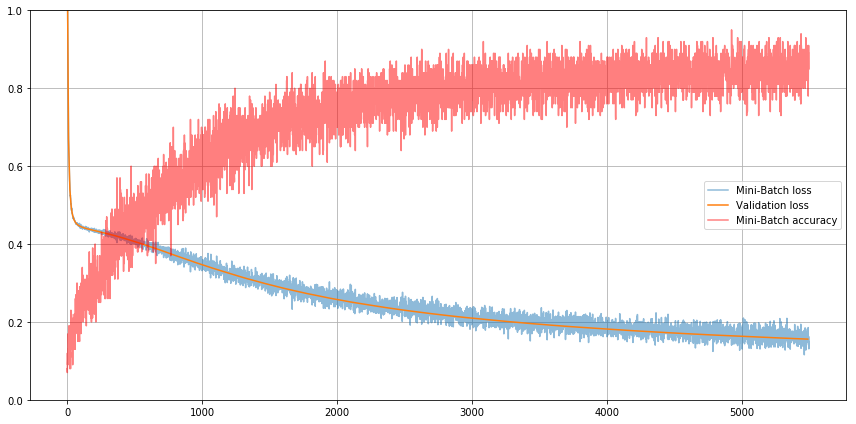

In [17]:
#
#   Plot Loss, Accuracy
#
print(expstr)
fig, ax = plt.subplots(figsize=[12,6])
ax.plot(losses['batch'], label='Mini-Batch loss', alpha=.5)
#ax.plot(losses['train'], label='Training loss')
xx = np.arange(0, len(losses['valid'])) * 10
ax.plot(xx, losses['valid'], label='Validation loss')
ax.plot(accurs['batch'], label='Mini-Batch accuracy', color='red', alpha=.5)

ax.legend()
ax.set_ylim(0, 1)
ax.grid()

plt.tight_layout()
plt.show;

---

Network: 196in->128sig->10sig   init_var=[0.071,0.088]   lr=0.03   batch=100   epochs=10


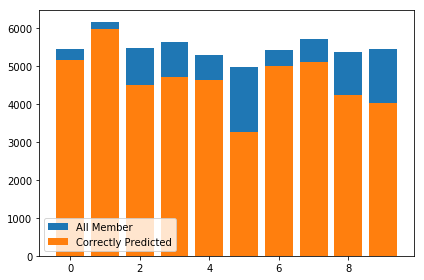

In [18]:
#
#   Per-class accuracy
#
print(expstr)
y_hat = fwd(train_x, W_hid, W_out, act_fun)
y_correct = np.argmax(train_y, axis=-1) == np.argmax(y_hat, axis=-1)
classes_correct = []
classes_all = []
for i in range(10):
    is_y_class_i = y_correct * (np.argmax(train_y, axis=-1)==i)
    nb_correct_class_i = np.sum(is_y_class_i)
    classes_correct.append(nb_correct_class_i)
    classes_all.append(np.count_nonzero(np.argmax(train_y,axis=-1)==i))
classes_correct = np.array(classes_correct)
classes_all = np.array(classes_all)

plt.bar(range(10), classes_all, label='All Member')
plt.bar(range(10), classes_correct, label='Correctly Predicted')
plt.legend(loc=3)
plt.tight_layout()
plt.show()

# Weight Plots

In [ ]:
def running_mean(x, n):
    return np.array([ np.mean(x[max(i-n+1, 0): i+1]) for i in range(len(x))])

In [ ]:
def running_std(x, n):
    return np.array([ np.std(x[max(i-n+1, 0): i+1]) for i in range(len(x))])

In [21]:
def plot_weights(data_iw, layer_name, axis=None):
    ni, nw = data_iw.shape   # iter, weights
    
    if axis is None:
        fig, axis = plt.subplots(1,1, figsize=[16,6])
    
    axis.plot(data_iw, alpha=max(100/nw, 0.002))
    axis.set_title(layer_name + ' Weights Neuron #' + str(neuron_nb))

In [19]:
def plot_update_ratios(data_iw, layer_name, mode='median', color='red', axis=None):
    ni, nw = data_iw.shape  # iter, weights
    
    data_delta_iw = data_iw[1:,:] - data_iw[:-1,:]       # delta
    ratio = data_delta_iw / data_iw[:-1,:]               # delta / weight
    ratio_abs = np.abs(ratio)
    
    if axis is None:
        fig, axis = plt.subplots(1,1, figsize=[16,6])
    
    if mode == 'raw':
        axis.plot(data_delta_iw, alpha=max(1/nw, 0.002), color='red');
        axis.set_title(layer_name + ' Delta Weights Neuron #' + str(neuron_nb))
        return

    if mode == 'fullmedian':
        axis.plot(ratio_abs, alpha=max(1/nw, 0.002), color='pink');
        
    if mode in ['median', 'fullmedian']:
        axis.plot(np.min(ratio_abs, axis=-1), alpha=.1, color=color);
        axis.plot(np.max(ratio_abs, axis=-1), alpha=.1, color=color);
        axis.plot(np.percentile(ratio_abs, 10, axis=-1), alpha=1, color=color, ls=':');     # Q1
        axis.plot(np.percentile(ratio_abs, 90, axis=-1), alpha=1, color=color, ls=':');     # Q3
        axis.plot(np.median(ratio_abs, axis=-1), alpha=1, color=color);
    
    if mode == 'norms':
        data_norm_i = np.linalg.norm(data_iw, axis=-1)
        data_delta_norm_i = np.linalg.norm(data_delta_iw, axis=-1)
        axis.plot(data_delta_norm_i/data_norm_i[:-1], alpha=1, color='green')
    
    if mode == 'DL4J':
        tmp_ = np.mean(np.abs(data_delta_iw), axis=-1) / np.mean(np.abs(data_iw[:-1,:]), axis=1)
        axis.plot(tmp_, color='blue')
    
    if mode == 'mean+std':
        mean_ = np.mean(ratio_abs, axis=-1)
        axis.plot(mean_, alpha=1, color='orange');
        std_ = np.std(ratio_abs, axis=-1)
        axis.plot(mean_ + std_, alpha=1, color='orange', ls=':');
        
    axis.plot([0,len(ratio_abs)],[.1, .1], alpha=.3, ls='--', c='black')
    axis.plot([0,len(ratio_abs)],[.01, .01], ls='-', c='black')
    axis.plot([0,len(ratio_abs)],[.001, .001], alpha=.3, ls='--', c='black')
    axis.set_yscale('log')
    axis.set_title(layer_name + ' abs( Delta / Weights )')


---

Network: 196in->128sig->10sig   init_var=[0.071,0.088]   lr=0.03   batch=100   epochs=10


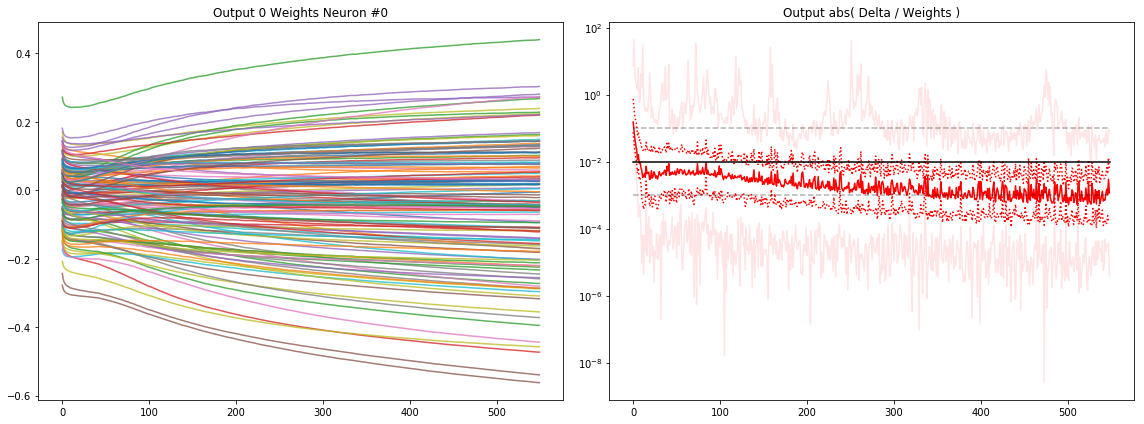

In [25]:
print(expstr)

neuron_nb = 0
tr_W_data = tr_W_out

fig, axes = plt.subplots(1, 2, figsize=[16,6])
ax1, ax2 = axes

ne, ni, nw, nn = tr_W_data.shape  # epochs, iter, weights, neurons
tr_W_data_iw = tr_W_data[:,:,:,neuron_nb].reshape([ne*ni,nw])  # iter, weight

plot_weights(tr_W_data_iw, 'Output '+str(neuron_nb), axis=ax1)
plot_update_ratios(tr_W_data_iw, 'Output', axis=ax2)

del tr_W_data

plt.tight_layout()
plt.show()

Network: 196in->128sig->10sig   init_var=[0.071,0.088]   lr=0.03   batch=100   epochs=10


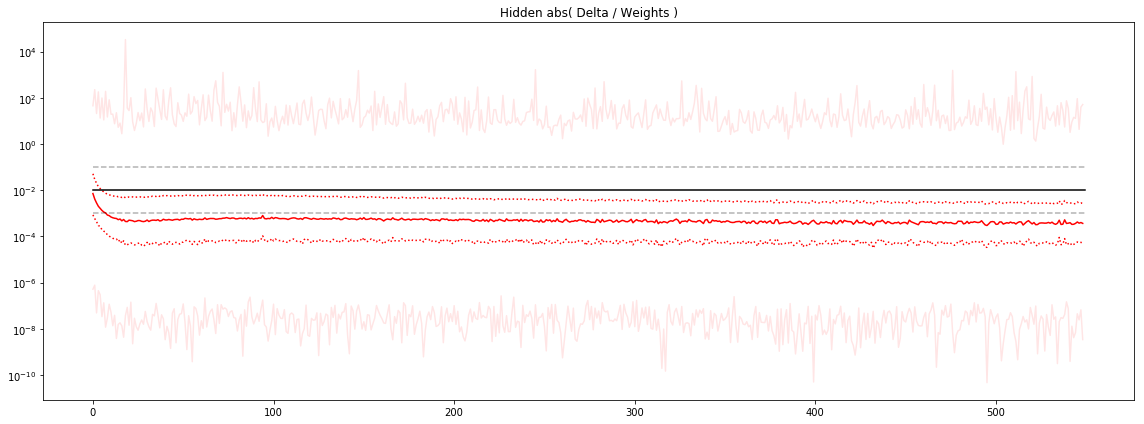

In [26]:
print(expstr)
fig, ax = plt.subplots(1, 1, figsize=[16,6])

ne, ni, nw, nn = tr_W_hid.shape  # epochs, iter, weights, neurons
tr_W_data_iw = tr_W_hid.reshape([ne*ni,-1])  # iter, all weights in layer

plot_update_ratios(tr_W_data_iw, 'Hidden', color='red', axis=ax)

plt.tight_layout()
plt.show()

Network: 196in->128sig->10sig   init_var=[0.071,0.088]   lr=0.03   batch=100   epochs=10


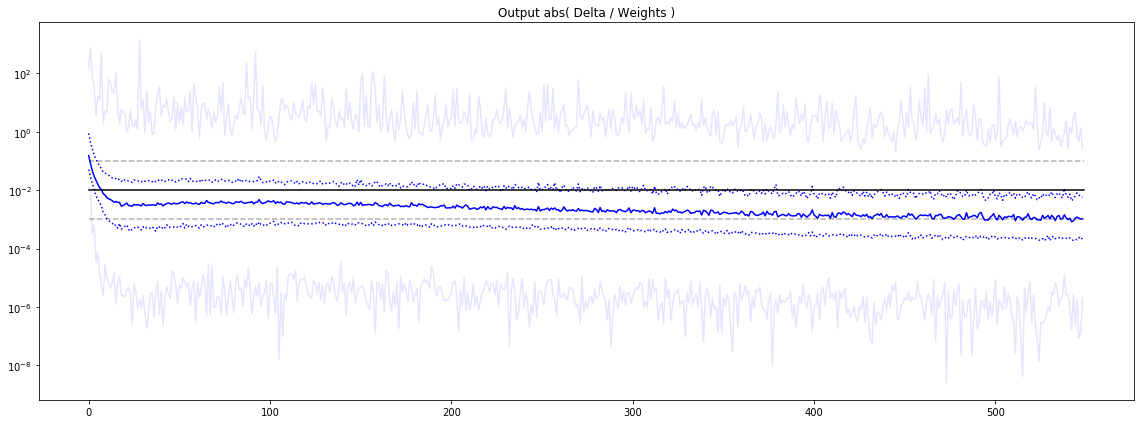

In [27]:
print(expstr)
fig, ax = plt.subplots(1, 1, figsize=[16,6])

ne, ni, nw, nn = tr_W_out.shape  # epochs, iter, weights, neurons
tr_W_data_iw = tr_W_out.reshape([ne*ni,-1])  # iter, all weights in layer

plot_update_ratios(tr_W_data_iw, 'Output', color='blue', axis=ax)

plt.tight_layout()
plt.show()

# Activation Histograms

In [18]:
def plot_3d_histogram(data, funct=lambda x: x, skip_first=False, lines_01=True, color=(1,0,0,1), alpha=1, ax=None, figsize=None):
    """
    
    Params:
        data - 2d array, dims: [epochs, samples].
               E.g. for single neuron activations: [[ 0.1, 0.2, 0.3, ... ]  activations in epoch 0, sample 1, 2, 3...
                                                    [ 0.2, 0.1, 0.3, ... ]  activations in epoch 1, ...
                                                    ...
                                                    [ 0.3, 0.1, 0.2, ... ]] activations is last training epoch
        funct - function to apply to data before plotting, e.g. sigmoid, tanh, usually none
    """
    assert data.ndim==2
    
    def interpolate_colors(cstart, cend, n):
        cstart, cend = np.array(cstart), np.array(cend)
        assert cstart.shape == (4,)
        assert cend.shape == (4,)
        if n == 1:  return cend    # if one step, then return end color

        cols = []
        for i in range(n):
            step = i/(n-1)
            cols.append( (1-step)*cstart + step*cend)
        return np.array(cols)
    
    color = np.array(color)
    color_start = np.array(color/4, dtype=float)  # transparent black
    color_end = np.array(color)
    colors = interpolate_colors(color_start, color_end, len(data))
    

    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111, projection='3d')
    
    
    ax.view_init(30, -85)
    # ax.set_xlim(0, 1)
    
    for epoch in range(len(data)):                                     # One line per epoch
        hist, bins = np.histogram(funct(data[epoch,:]), bins=100)      # apply funct and create histogram
        bins = (bins[:-1] + bins[1:])/2                                # center bins
        hist = hist / np.sum(hist)
        
        hist_0 = hist[0]
        if skip_first:
            bins = bins[1:]
            hist = hist[1:]
        
        ax.plot(xs=bins, ys=hist,
                zs=-epoch,
                zdir='y', 
                color=colors[epoch])
        nb_epochs = len(data)
        if epoch == 0 and lines_01:
            ax.plot(xs=[0,0], ys=[0,0], zs=[-nb_epochs,0], zdir='y', color='k')
            ax.plot(xs=[1,1], ys=[0,0], zs=[-nb_epochs,0], zdir='y', color='k', ls='--')
        if epoch == len(data)-1:
            ax.plot(xs=[bins[0],bins[-1]], ys=[0,0], zs=-nb_epochs, zdir='y', color='k')
    
    if skip_first:
        ax.set_xlabel('value ('+str(round(hist_0*100, 2)) + '%)'); ax.set_ylabel('epoch'); ax.set_zlabel('n')
    else:
        ax.set_xlabel('value'); ax.set_ylabel('epoch'); ax.set_zlabel('n')
    #print('hist[0]:', round(hist_0, 2))

---

Network: 196in->128sig->10sig   init_var=[0.071,0.088]   lr=0.03   batch=100   epochs=10


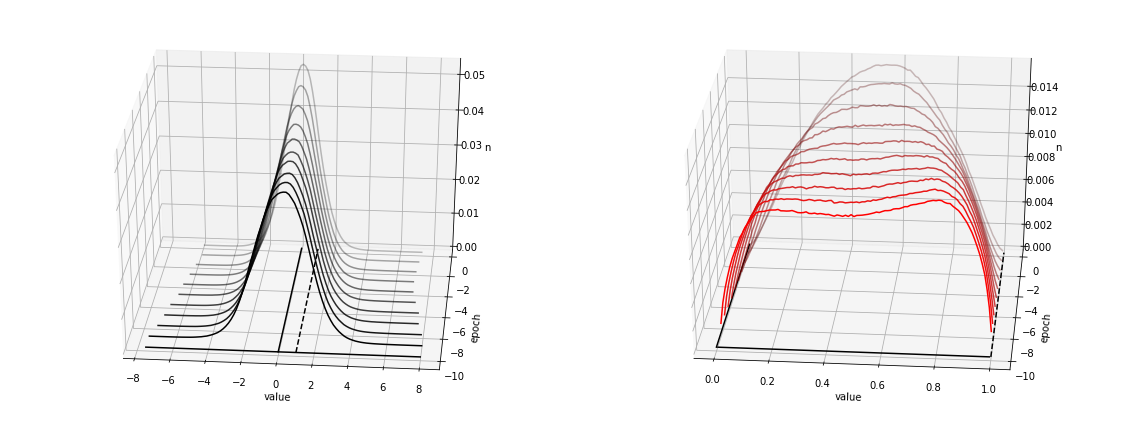

In [19]:
#
#   Hidden ACTIATION HISTOGRAM
#
print(expstr)
fig = plt.figure(figsize=[16,6])

ax = fig.add_subplot(121, projection='3d')
ne, ni, na, nn = tr_z_hid.shape
dd = tr_z_hid.reshape([ne,-1])
plot_3d_histogram(dd, funct=lambda x: x, color=(0,0,0,1), ax=ax)

ax = fig.add_subplot(122, projection='3d')
plot_3d_histogram(dd, funct=lambda x: act_fun(x), skip_first=False, color=(1,0,0,1), ax=ax)


plt.tight_layout()
plt.show()

Network: 196in->128sig->10sig   init_var=[0.071,0.088]   lr=0.03   batch=100   epochs=10


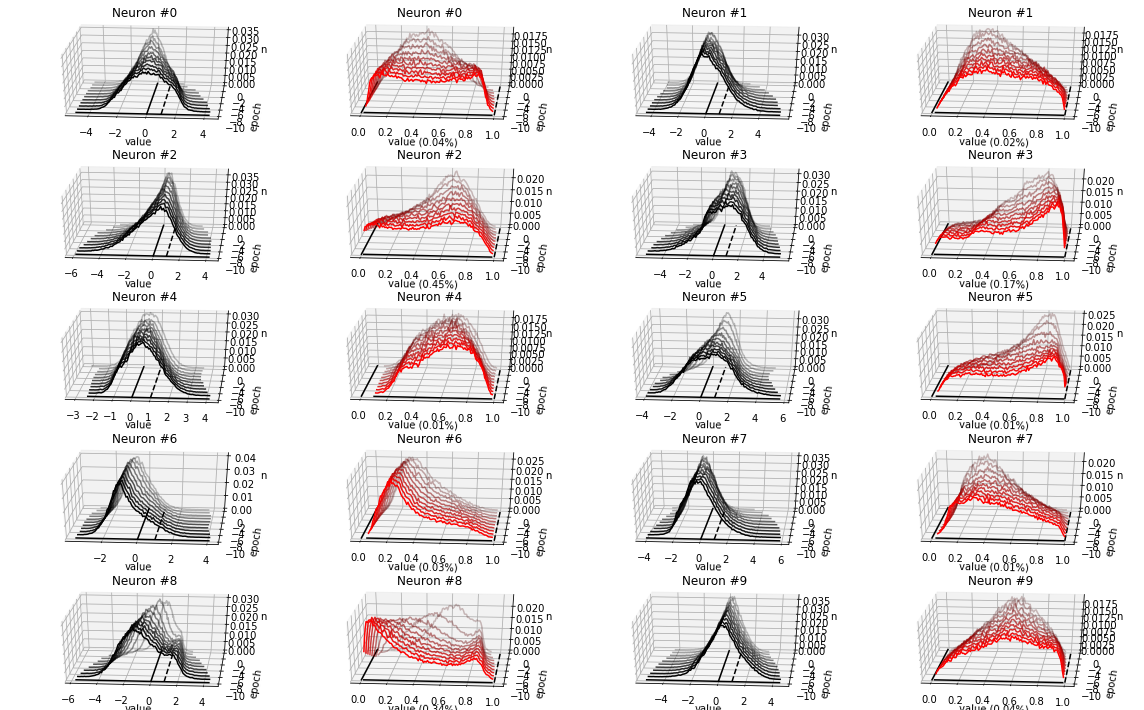

In [20]:
#
#   Hidden NEURONS ACTIVATIONS
#
print(expstr)
ne, ni, na, nn = tr_z_hid.shape
plot_n = 10  # tr_z_hid.shape[-1]
fig = plt.figure(figsize=[16,2*plot_n/2])

tmp_act_hid = tr_z_hid.reshape([ne,ni*na,nn])
for n in range(plot_n):
    
    ax = fig.add_subplot(plot_n/2, 4, (n*2)+1, projection='3d')
    plot_3d_histogram(tmp_act_hid[:,:,n], funct=lambda x: x, color=(0,0,0,1), ax=ax)
    ax.set_title('Neuron #' + str(n))
    
    ax = fig.add_subplot(plot_n/2, 4, (n*2)+2, projection='3d')
    plot_3d_histogram(tmp_act_hid[::,:,n], funct=lambda x: act_fun(x), skip_first=True, color=(1,0,0,1), ax=ax)
    ax.set_title('Neuron #' + str(n))

plt.tight_layout()
plt.show()

---

Network: 196in->128sig->10sig   init_var=[0.071,0.088]   lr=0.03   batch=100   epochs=10


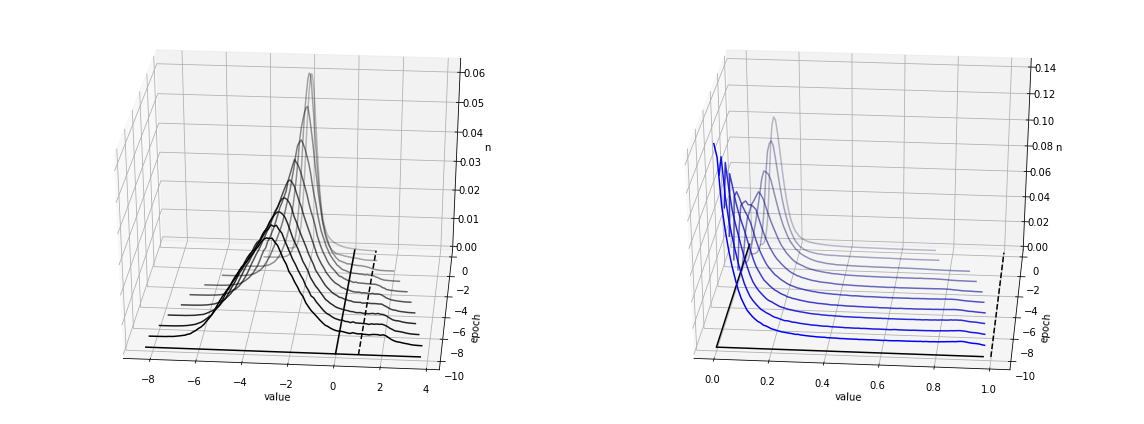

In [22]:
#
#   Output ACTIATION HISTOGRAM
#
print(expstr)
fig = plt.figure(figsize=[16,6])

ax = fig.add_subplot(121, projection='3d')
ne, ni, na, nn = tr_z_out.shape
dd = tr_z_out.reshape([ne,-1])
plot_3d_histogram(dd, funct=lambda x: x, color=(0,0,0,1), ax=ax)

ax = fig.add_subplot(122, projection='3d')
plot_3d_histogram(dd, funct=lambda x: sigmoid(x), color=(0,0,1,1), ax=ax)


plt.tight_layout()
plt.show()

Network: 196in->128sig->10sig   init_var=[0.071,0.088]   lr=0.03   batch=100   epochs=10


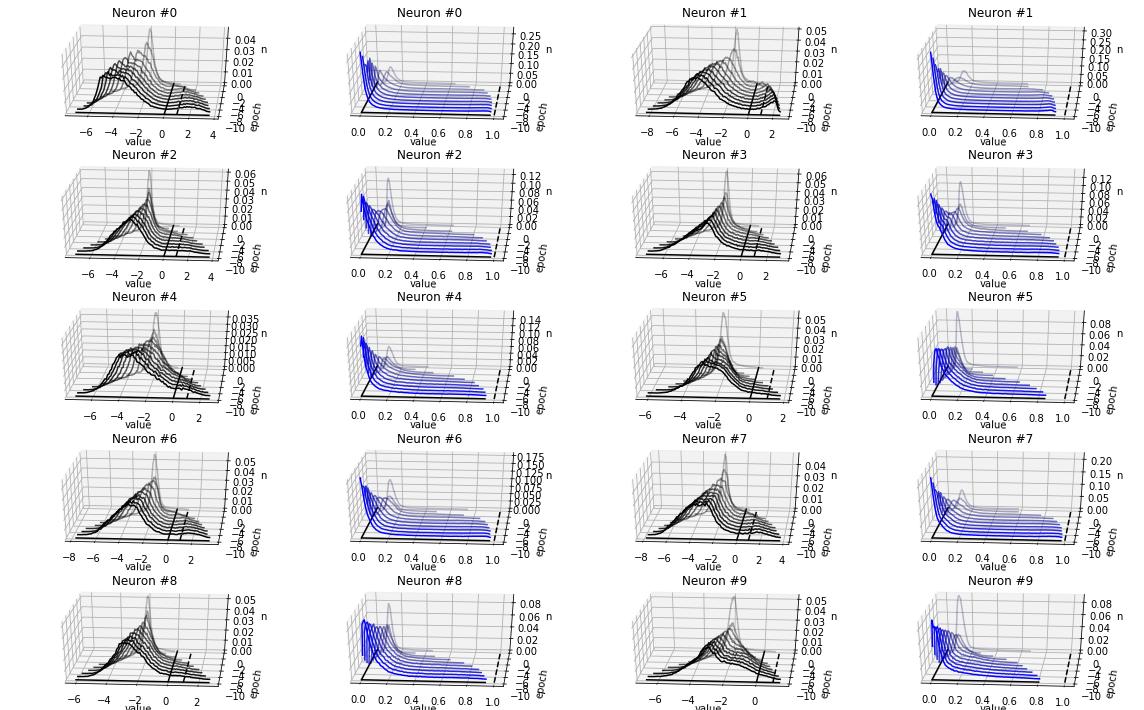

In [23]:
#
#   Output NEURONS ACTIVATIONS
#
print(expstr)
ne, ni, na, nn = tr_z_out.shape
fig = plt.figure(figsize=[16,2*nn/2])

tmp_act_out = tr_z_out.reshape([ne,ni*na,nn])
for n in range(tr_z_out.shape[-1]):
    
    ax = fig.add_subplot(nn/2, 4, (n*2)+1, projection='3d')
    plot_3d_histogram(tmp_act_out[:,:,n], funct=lambda x: x, color=(0,0,0,1), ax=ax)
    ax.set_title('Neuron #' + str(n))
    
    ax = fig.add_subplot(nn/2, 4, (n*2)+2, projection='3d')
    plot_3d_histogram(tmp_act_out[:,:,n], funct=lambda x: sigmoid(x), color=(0,0,1,1), ax=ax)
    ax.set_title('Neuron #' + str(n))

plt.tight_layout()
plt.show()

# Other